In [4]:
import numpy as np
import random
import os
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader


## 工具函数

In [5]:
def make_regression_dataset(train_num=7000, test_num=3000, feat_num=500):
    """
    手动生成回归任务的数据集，要求：
    
    生成单个数据集，数据集的大小为10000且训练集大小为7000，测试集大小为3000。
    
    数据集的样本特征维度p为500
    """
    x = torch.randn((train_num, feat_num))
    y = (
        0.028
        + torch.sum(0.0056 * x)
        + torch.normal(mean=0, std=0.01, size=(train_num, 1))
    )
    train_x = x[:test_num]
    train_y = y[:test_num]
    test_x = x[test_num:]
    test_y = y[test_num:]
    train_data = TensorDataset(train_x, train_y)
    train_iter = DataLoader(train_data, batch_size=50, shuffle=True)
    test_data = TensorDataset(test_x, test_y)
    test_iter = DataLoader(test_data, batch_size=50, shuffle=False)
    return train_iter, test_iter


def make_classify_dataset(train_num=7000, test_num=3000, feat_num=200):
    """
    共生成两个数据集。
    
    两个数据集的大小均为10000且训练集大小为7000，测试集大小为3000。
    
    两个数据集的样本特征x的维度均为200，且分别服从均值互为相反数且方差相同的正态分布。
    
    两个数据集的样本标签分别为0和1。
    """
    x1 = torch.normal(size=(train_num + test_num, feat_num), mean=1, std=1)
    y1 = torch.zeros(x1.shape[0], dtype=torch.float32)
    x2 = torch.normal(size=(train_num + test_num, feat_num), mean=-1, std=1)
    y2 = torch.ones(x2.shape[0], dtype=torch.float32)

    train_x = torch.cat([x1[:train_num], x2[:train_num]], dim=0)
    train_y = torch.cat([y1[:train_num], y2[:train_num]], dim=0)
    train_data = TensorDataset(train_x, train_y)
    train_iter = DataLoader(train_data, batch_size=50, shuffle=True)

    test_x = torch.cat([x1[train_num:], x2[train_num:]], dim=0)
    test_y = torch.cat([y1[train_num:], y2[train_num:]], dim=0)
    test_data = TensorDataset(test_x, test_y)
    test_iter = DataLoader(test_data, batch_size=50, shuffle=False)
    # print(f"Class distribution: {torch.bincount(train_y.long())}")
    return train_iter, test_iter

def make_minist_dataset():
    """
    该数据集包含60,000个用于训练的图像样本和10,000个用于测试的图像样本。
    
    图像是固定大小(28x28像素)，其值为0到1。为每个图像都被平展并转换为784(28 * 28)个特征的一维numpy数组。
    """    
    train_data=tv.datasets.MNIST(root='./mnist_dataset',train=True,download=True,transform=tv.transforms.ToTensor())
    test_data=tv.datasets.MNIST(root='./mnist_dataset',train=False,download=True,transform=tv.transforms.ToTensor())
    train_iter=torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=0)
    return train_iter, test_iter

In [6]:
class Forward_Net(torch.nn.Module):
    """
    手动实现前馈神经网络解决回归问题
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(Forward_Net, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_size))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_size, output_size))
        self.b2 = torch.nn.Parameter(torch.randn(output_size))
        torch.nn.init.xavier_normal_(self.w1)
        torch.nn.init.constant_(self.b1, 0.1)
        torch.nn.init.xavier_normal_(self.w2)
        torch.nn.init.constant_(self.b2, 0.1)
        self.params = [self.w1, self.b1, self.w2, self.b2]
        
    def forward(self, x):
        x = torch.relu(torch.matmul(x, self.w1) + self.b1)
        x = torch.matmul(x, self.w2) + self.b2
        return x

In [7]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size
        param.grad.data.zero_()
        
def calc_net_loss(net: Forward_Net, test_iter: DataLoader, loss_func: torch.nn.Module):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_iter:
            pred = net(x)
            test_loss += loss_func(pred, y.unsqueeze(1)).item()
    return test_loss / len(test_iter)




## 任务一：手动实现前馈神经网络解决回归问题

c:\Users\jcheng\.conda\envs\dl\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 4.0063670138518015, Test Loss: 1.4538487203419208
Epoch 2, Train Loss: 1.1433809647957485, Test Loss: 1.057636995613575
Epoch 3, Train Loss: 0.98722851673762, Test Loss: 0.9919992193579674
Epoch 4, Train Loss: 0.9274170905351639, Test Loss: 0.9475791096687317
Epoch 5, Train Loss: 0.8755859096844991, Test Loss: 0.9059679809957742
Epoch 6, Train Loss: 0.8280507365862528, Test Loss: 0.8680428542196751
Epoch 7, Train Loss: 0.7849298506975174, Test Loss: 0.8334687758237124
Epoch 8, Train Loss: 0.7449732234080633, Test Loss: 0.8010915078222751
Epoch 9, Train Loss: 0.7082625528176626, Test Loss: 0.7714025199413299
Epoch 10, Train Loss: 0.674373968442281, Test Loss: 0.7440731935203075
Epoch 11, Train Loss: 0.6431467706958452, Test Loss: 0.7179868835955858
Epoch 12, Train Loss: 0.614233993490537, Test Loss: 0.6937776222825051
Epoch 13, Train Loss: 0.5872798879941304, Test Loss: 0.6711972843855619
Epoch 14, Train Loss: 0.5623593444625536, Test Loss: 0.6506947457790375
Epoch 

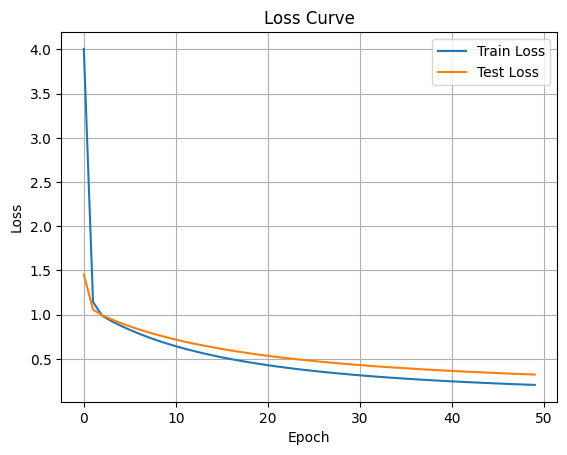

In [8]:
batch_size = 50
lr = 0.01
loss_func = torch.nn.MSELoss()
epoch_num = 50

train_iter, test_iter = make_regression_dataset()
net = Forward_Net(500, 256, 1)

train_loss, test_loss = [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        pred = net(x)
        loss = loss_func(pred, y.unsqueeze(1))
        loss.backward()
        sgd(net.params, lr, batch_size)
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()

<!-- 实验结果分析：通过模型训练，随着epoch增加，训练集的loss逐渐降低，同时测试集的loss也逐渐降低，表明模型在回归任务中学习的参数逐渐趋于优 -->

## 任务二：手动实现前馈神经网络解决二分类问题

In [9]:
def calc_net_acc(net: Forward_Net, test_iter: DataLoader):
    net.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in test_iter:
            pred = net(x)
            predicted_labels = (torch.sigmoid(pred) > 0.5).squeeze(1).long()
            correct_predictions += (predicted_labels == y.long()).sum().item()
            total_samples += y.size(0)
    return correct_predictions / total_samples

Epoch 1, Train Loss: 0.21788941659033298, Test Loss: 0.20713761541992426, Test Acc: 0.9418333333333333
Epoch 2, Train Loss: 0.19647896949734006, Test Loss: 0.18747605032597978, Test Acc: 0.9541666666666667
Epoch 3, Train Loss: 0.1783846340807421, Test Loss: 0.1707829337567091, Test Acc: 0.965
Epoch 4, Train Loss: 0.16296090685895512, Test Loss: 0.1564984195244809, Test Acc: 0.9748333333333333
Epoch 5, Train Loss: 0.14970823675394057, Test Loss: 0.1441799578567346, Test Acc: 0.9793333333333333
Epoch 6, Train Loss: 0.1382336071293269, Test Loss: 0.1334715227596462, Test Acc: 0.9826666666666667
Epoch 7, Train Loss: 0.1282297805483852, Test Loss: 0.12409965178618829, Test Acc: 0.9853333333333333
Epoch 8, Train Loss: 0.11944822333753109, Test Loss: 0.11584607892048855, Test Acc: 0.9883333333333333
Epoch 9, Train Loss: 0.11169492934963533, Test Loss: 0.10853820831204454, Test Acc: 0.9903333333333333
Epoch 10, Train Loss: 0.10481033846735954, Test Loss: 0.10202991858435174, Test Acc: 0.992166

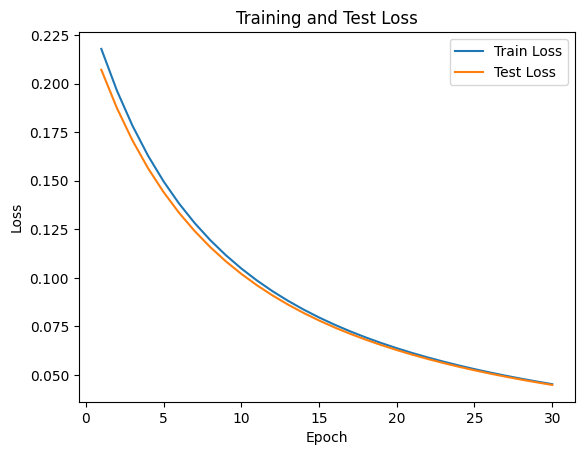

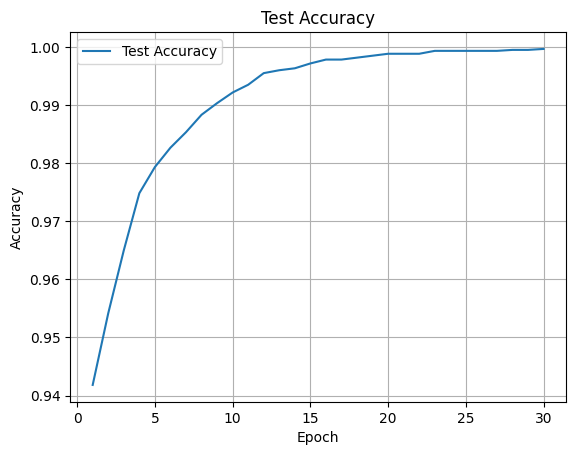

In [10]:
batch_size = 50
lr = 0.001
loss_func = torch.nn.BCEWithLogitsLoss()
epoch_num = 30

train_iter, test_iter = make_classify_dataset()
net = Forward_Net(200, 100, 1)

train_loss, test_loss, test_acc = [], [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        pred = net(x)
        loss = loss_func(pred, y.unsqueeze(1))
        loss.backward()
        sgd(net.params, lr, batch_size)
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    test_acc.append(calc_net_acc(net, test_iter))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_acc[-1]}")

# 损失曲线
plt.plot(range(1, epoch_num+1), train_loss, label='Train Loss')
plt.plot(range(1, epoch_num+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 测试准确率
plt.plot(range(1, epoch_num+1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

实验结果分析：随着epoch增加，模型在训练集和测试集上的loss都逐渐降低，说明模型在二分类任务的学习中逐渐优化，并且模型的学习速度也是较快的。

## 任务三：手动实现前馈神经网络解决多分类问题

In [11]:
from torch import Tensor

def calc_net_loss(net: Forward_Net, test_iter: DataLoader, loss_func: torch.nn.Module):
    net.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, y in test_iter:
            x = x.view(-1, 28*28)
            pred:Tensor = net(x)
            loss = loss_func(pred, y)
            loss_sum += loss.item()
    return loss_sum / len(test_iter)

def calc_net_acc(net: Forward_Net, test_iter: DataLoader):
    net.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in test_iter:
            x = x.view(-1, 28*28)
            pred:Tensor = net(x)
            predicted_labels = pred.argmax(dim=1).long()
            correct_predictions += (predicted_labels == y.long()).sum().item()
            total_samples += y.size(0)
    return correct_predictions / total_samples

Epoch 1, Train Loss: 2.0311978491465252, Test Loss: 1.7203397004368206, Test Acc: 0.6169
Epoch 2, Train Loss: 1.5118866578420003, Test Loss: 1.302172949519782, Test Acc: 0.7379
Epoch 3, Train Loss: 1.1854246549924214, Test Loss: 1.04221810129123, Test Acc: 0.7854
Epoch 4, Train Loss: 0.9803962494850159, Test Loss: 0.8778210047144479, Test Acc: 0.8107
Epoch 5, Train Loss: 0.8470211237589518, Test Loss: 0.7684111496130117, Test Acc: 0.8292
Epoch 6, Train Loss: 0.7555449597835541, Test Loss: 0.691723952135339, Test Acc: 0.845
Epoch 7, Train Loss: 0.6894535228729248, Test Loss: 0.6350994686158701, Test Acc: 0.8564
Epoch 8, Train Loss: 0.6395265071074168, Test Loss: 0.5917038447178972, Test Acc: 0.8635
Epoch 9, Train Loss: 0.6004983925501506, Test Loss: 0.5573420871656162, Test Acc: 0.869
Epoch 10, Train Loss: 0.5691335016727448, Test Loss: 0.5295421573253104, Test Acc: 0.8737
Epoch 11, Train Loss: 0.5433208794593811, Test Loss: 0.5064760827884888, Test Acc: 0.8782
Epoch 12, Train Loss: 0.5

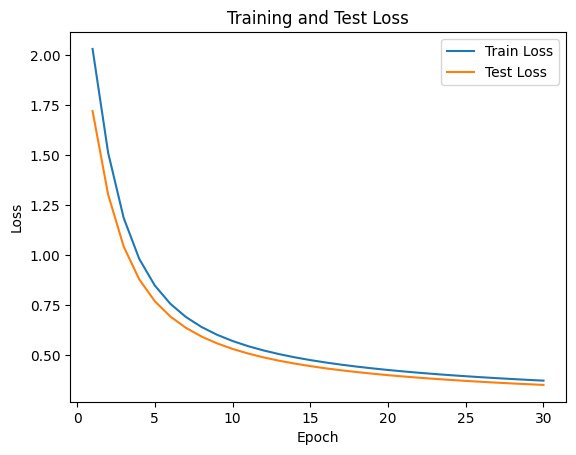

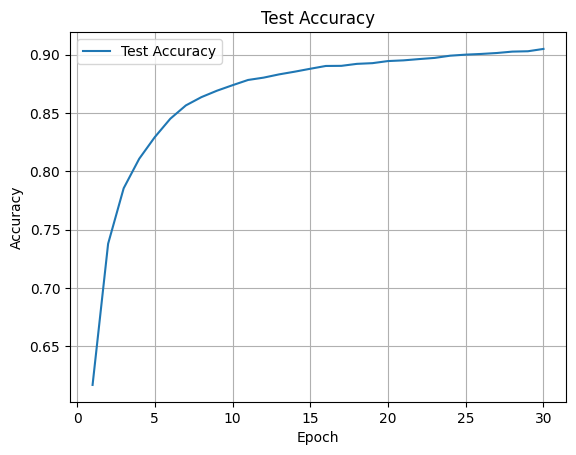

In [12]:
batch_size = 32
lr = 0.01
loss_func = torch.nn.CrossEntropyLoss()
epoch_num = 30

train_iter, test_iter = make_minist_dataset()
net = Forward_Net(28*28, 256, 10)

train_loss, test_loss, test_acc = [], [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        x = x.view(-1, 28*28)
        pred = net(x)
        # print(x.shape, x.view(-1, 28*28).shape, pred.shape, y.shape)
        loss = loss_func(pred, y)
        loss.backward()
        sgd(net.params, lr, batch_size)
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    test_acc.append(calc_net_acc(net, test_iter))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_acc[-1]}")

# 损失曲线
plt.plot(range(1, epoch_num+1), train_loss, label='Train Loss')
plt.plot(range(1, epoch_num+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 测试准确率
plt.plot(range(1, epoch_num+1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

实验结果分析：随着epoch增加，训练集和测试集上的loss逐渐降低，准确率逐渐提高，表明模型在解决多分类任务的训练过程中不断优化，并拥有了较好的泛化能力。